Generating a mandelbrot set 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from numpy import complex
import math

WIDTH = 500


1. Pure Python

In [3]:
def mandelbrot_pp(w):
    def get_colour(x):
        return (int(255*(1+math.cos(3.32*math.log(x)))/2),
                int(255*(1+math.cos(0.774*math.log(x)))/2),
                int(255*(1+math.cos(0.412*math.log(x)))/2))
    pixels = [[(0, 0, 0) for j in range(w)] for i in range(w)]
    for x in range(w):
        for y in range(w):
            pixels[x][y] = (0, 0, 0)
            c0 = complex(3.0*x/w -2 , 3.0*y/w -1.5)
            c = 0
            for i in range(1, 1024):
                if abs(c) > 2:
                    pixels[x][y] = get_colour(i)
                    break
                c = c*c + c0
    return pixels

In [4]:
import time
seconds0 = time.time()
calcpixels = mandelbrot_pp(WIDTH)
seconds1 = time.time()
print("Time reqd in seconds =", seconds1 - seconds0)

Time reqd in seconds = 5.755230665206909


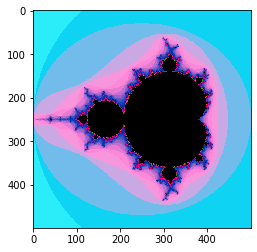

In [5]:
Img = Image.new('RGB', (WIDTH, WIDTH))
pixels = Img.load()
for x in range(Img.size[0]):
    for y in range(Img.size[1]):
        pixels[x, y] = calcpixels[x][y]
plt.imshow(Img)
    

In [6]:
from numba import njit

@njit
def mandelbrot_nb(w):
    def get_colour(x):
        return (int(255*(1+math.cos(3.32*math.log(x)))/2),
                int(255*(1+math.cos(0.774*math.log(x)))/2),
                int(255*(1+math.cos(0.412*math.log(x)))/2))
    pixels = [[(0, 0, 0) for j in range(w)] for i in range(w)]
    for x in range(w):
        for y in range(w):
            pixels[x][y] = (0, 0, 0)
            c0 = complex(3.0*x/w -2 , 3.0*y/w -1.5)
            c = 0
            for i in range(1, 1024):
                if abs(c) > 2:
                    pixels[x][y] = get_colour(i)
                    break
                c = c*c + c0
    return pixels

In [7]:
import time
seconds0 = time.time()
calcpixels = mandelbrot_nb(WIDTH)
seconds1 = time.time()
print("Time reqd in seconds =", seconds1 - seconds0)

Time reqd in seconds = 0.8364846706390381


2. Exercise 2

In [8]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
w = h = 10
dx = dy = 0.1
D = 4.0
Tcool, Thot = 300.0, 700.0
nx, ny = int(w/dx), int(h/dy)
dx2, dy2 = dx*dx, dy*dy
dt = dx2*dy2/(2*D*(dx2 + dy2))
nsteps = 301
def init_pp():
    u0 = [[Tcool]*ny for _ in range(nx)]
    for x in range(nx):
        for y in range(ny):
            if x==0 or y==0 or x==nx-1 or y==ny-1:
                u0[x][y] = Thot
    return u0
def do_timestamp_purepy(u0):
    u = [[Thot]*ny for _ in range(nx)]
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            uxx = u0[i+1][j] - 2*u0[i][j] + u0[i-1][j] /dx2
            uyy = u0[i][j+1] - 2*u0[i][j] + u0[j][j-1] /dy2
            u[i][j] = u[i][j] + dt * D* (uxx+uyy)
    return u

Time reqd in seconds = 1.602823257446289


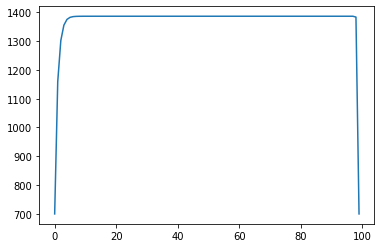

In [9]:
seconds0 = time.time()
u0 = init_pp()
for n in range(nsteps):
    u0 = do_timestamp_purepy(u0)
seconds1 = time.time()

print("Time reqd in seconds =", seconds1 - seconds0)

plt.plot(u0[51])

In [10]:
from numba import njit

def init():
    u0 = Tcool*np.ones((nx, ny))
    u0[:, 0] = Thot
    u0[:, -1] = Thot
    u0[0, :] = Thot
    u0[-1, :] = Thot
    return u0

@njit
def do_timestamp_nb(u0):
    u = u0.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            uxx = u0[i+1][j] - 2*u0[i][j] + u0[i-1][j] /dx2
            uyy = u0[i][j+1] - 2*u0[i][j] + u0[j][j-1] /dy2
            u[i][j] = u[i][j] + dt * D* (uxx+uyy)
    return u

In [11]:
import time
seconds0 = time.time()
u0 = init()
for n in range(nsteps):
    u0 = do_timestamp_nb(u0)
seconds1 = time.time()
print("Time reqd in seconds =", seconds1 - seconds0)

Time reqd in seconds = 0.14946889877319336


Exercise 3 -Kmeans

In [25]:
%matplotlib inline
from sklearn.cluster import KMeans
df = pd.read_csv('/home/neil/scipy19/numba/dish.csv')
kmeans = KMeans(n_clusters=10, init='random', max_iter=20).fit(df)

<BarContainer object of 10 artists>

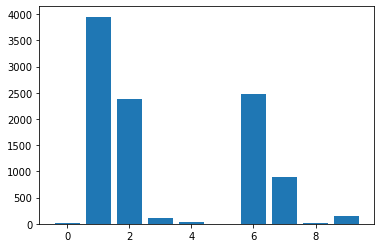

In [26]:
assignments = kmeans.labels_
iterations = kmeans.n_iter_
centroids = kmeans.cluster_centers_
X, Y = np.unique(assignments, return_counts=True)
plt.bar(X, Y)

In [28]:
from numba.types import Tuple
from numba import int8, int32, float64, prange

def kmean_np(X, n_clusters, max_iter):
    centroids = X[np.random.choice(np.arange(len(x)), n_clusters), :]
    C = np.zeros(X.shape[0], dtype = np.int8)
    for i in range(max_iter):
        for x_i in range(X.shape[0]):
            min_d = np.inf
            for y_k in range(n_clusters):
                d = np.dot(X[x_i, :]-centroids[y_k, :], X[x_i,:]-centroids)
                if d < min_d:
                    min_d = d
                    C[x_i] = y_k
        for k in range(n_clusters):
            df_n = X[C==k]
            centroids[k] = df_n.sum(axis=0)/len(df_n)
                
    return centroids, C